# Updates

！！Submission for tasks A uses 3-class

24/02 updates: Added Results analysis function, tried task B

20/02 updates: Try both Conv1d+LSTM in text model and fusion model 

19/02 updates: Add Capsule Network

18/02 updates: Build .py file from this notebook for runing on the GPU console. And Try the task B as well. 

17/02 updates: Build text+img model. Mix text embedding and img data by concat them into one tensor. 3-class: 0.6, 5-class: 0.4459

16/02 updates: Add data augmentation. Also, use classes_weights to handle data imbanlance in training. 

15/02 updates: Uploaded the *data_7000_corrected.csv*, it fixes the data input error. Also uploaded the *data_7000_processed.csv*, it ignores 26 missing images (actual rows 6974) and contains img size attributes. 


# Import Modules

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import os
from numpy import asarray
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import * 

import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
from tensorflow.python.client import device_lib
if __name__ == "__main__":
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 997049754961436564
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10933293058692373112
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 834824278134010862
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11833155542750369699
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Data Preparation

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/SemEval_2020

/content/drive/My Drive/SemEval_2020


## Read CSV Data

In [0]:
PATH_CSV = "./data_7000_processed.csv" # use pre-processed data, it ignores 26 missing images, actual enties are 6974
PATH_IMG = "./memotion_analysis_training_data/data_7000/"

data = pd.read_csv(PATH_CSV, index_col=0)  
# data.columns = ['Image_name', 'Image_URL', 'OCR_extracted_text', 'corrected_text',
#        'Humour', 'Sarcasm', 'offensive', 'Motivational', 'Overall_Sentiment']
data.shape

(6974, 11)

In [0]:
data.head()

,Image_name,Image_URL,OCR_extracted_text,corrected_text,Humour,Sarcasm,offensive,Motivational,Overall_Sentiment,img_width,img_height
0,10_year_10-year-challenge_1547788782.jpeg,https://spiderimg.amarujala.com/assets/images/...,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive,749,506
1,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,https://www.lifewire.com/thmb/8wNfd94_meE9X2cp...,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive,766,571
2,10_year_10-year-challenge-sweet-dee-edition-40...,https://pics.conservativememes.com/10-year-cha...,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive,500,334
3,10_year_10-year-challenge-with-no-filter-47-hi...,https://pics.me.me/10-year-challenge-with-no-f...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral,500,429
4,10_year_10-years-challenge.jpg,https://i0.wp.com/beyondblindfold.com/wp-conte...,"What if the ""10 Year Challenge"" was created by...","What if the ""10 Year Challenge"" was created by...",hilarious,general,slight,not_motivational,very_positive,780,399


Show how many pictures in each class

In [0]:
data['Overall_Sentiment'].value_counts() #corrected data

positive         3117
neutral          2198
very_positive    1030
negative          479
very_negative     150
Name: Overall_Sentiment, dtype: int64

In [0]:
# # replace wrong data
# data.replace('positivechandler_Friday-Mood-AF.-meme-Friends-ChandlerBing.jpg', 'positive',inplace=True)
# #or delete wrong data
# # data = data[data['Overall_Sentiment'].isin(['positive','neutral','very_positive','negative','very_negative'])]
# data['Overall_Sentiment'].value_counts()

In [0]:
Y_3 = data['Overall_Sentiment']
Y_3 = Y_3.replace('very_positive','positive').replace('very_negative','negative')
data['taskA'] = Y_3
print(data['taskA'].value_counts())

num_class = 3
Y_3 = to_categorical(Y_3.factorize()[0])

# use classes weights to handle data imbalance
trainYcate3 = [np.argmax(i) for i in Y_3]
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(trainYcate3),
                                                 trainYcate3)
class_weights

positive    4147
neutral     2198
negative     629
Name: taskA, dtype: int64


array([0.56056587, 1.05762815, 3.69581346])

In [0]:
data.iloc[:,0:9].describe()

,Image_name,Image_URL,OCR_extracted_text,corrected_text,Humour,Sarcasm,offensive,Motivational,Overall_Sentiment
count,6974,6974,6814,6965,6974,6974,6974,6974,6974
unique,6973,6940,6620,6915,4,4,4,2,5
top,hillary_c3fd01300e5bee2ba12a45ee2f160ed11b8926...,"""https://images.complex.com/complex/image/uplo...","<html><head><meta content=""text/html; charset=...",#NAME?,funny,general,not_offensive,not_motivational,positive
freq,2,10,110,5,2449,3502,2704,4515,3117


In [0]:
data.describe()

,img_width,img_height
count,6974.000000,6974.000000
mean,587.009177,546.542587
std,256.502679,249.617494
min,100.000000,123.000000
25%,480.000000,392.000000
50%,500.000000,500.000000
75%,640.000000,648.750000
max,4961.000000,5553.000000


In [0]:
data['Sarcasm'].value_counts()

general            3502
twisted_meaning    1542
not_sarcastic      1538
very_twisted        392
Name: Sarcasm, dtype: int64

In [0]:
data['Motivational'].value_counts()

not_motivational    4515
motivational        2459
Name: Motivational, dtype: int64

In [0]:
data['offensive'].value_counts()

not_offensive        2704
slight               2587
very_offensive       1463
hateful_offensive     220
Name: offensive, dtype: int64

In [0]:
data['Humour'].value_counts()

funny         2449
very_funny    2231
not_funny     1646
hilarious      648
Name: Humour, dtype: int64

Random sampling for each class to create ***balanced*** data

reducing the data set is a bad practice

In [0]:
minClassItem = data['taskA'].value_counts().min()
data_balanced = data.groupby('taskA',group_keys=False).apply(lambda x: x.sample(minClassItem, random_state=0))

data = data_balanced
data.shape

(1887, 12)

In [0]:
data['taskA'].value_counts()

negative    629
neutral     629
positive    629
Name: taskA, dtype: int64

## Read Image data

In [0]:
# #use pillow, use the same data for missing channels in error image

# size = 73, 50
# X = [ ]     # creating an empty array
# error = []
# for img_name in tqdm(data['Image_name']):
#   if(os.path.isfile(PATH_IMG + img_name)):
#     image = Image.open(PATH_IMG + img_name)
#     img = asarray(image.resize(size))
#     if img.ndim != 3:
#       img = np.dstack([img, img, img])
#       error.append(img_name)
#     X.append(img)  # storing each image in array X
#   else:
#     error.append(img_name)
# X = np.array(X)    # converting list to array
# print(error)

In [0]:
## use cv2, and delete 2-channel error image
c = 0
size = 128,128  # img size: height, width 
X = [ ]     # creating an empty array
error = []
for img_name in tqdm(data['Image_name']):
  c += 1
#   image = Image.open(PATH_IMG + img_name)
#   img = asarray(image.resize(size))
  if(os.path.isfile(PATH_IMG + img_name)):
    image = cv2.imread((PATH_IMG + img_name), cv2.IMREAD_COLOR)
    if image is not None:
#       pass
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, size)
      if img.ndim != 3:                  # if the image is not RGB
        img = np.dstack([img, img, img]) # use the same value for the 3 RGB channels
      X.append(img)  # storing each image in array X
    else:
      print('None:{}'.format(img_name))
      error.append(img_name)
  else:
    print('Not Exists:{}'.format(img_name))
    error.append(img_name)
#   print(c,img.shape, img_name) # print each image infomaiton

print(error)
X = np.array(X)   # converting list to array

In [0]:
data = data[~data['Image_name'].isin(error)] # delete data of error images

# Y = data['Overall_Sentiment']
Y = data['taskA'] #Y_3
num_class = 5
Y = to_categorical(Y.factorize()[0])

width, height, channels = X.shape[1:]

## *Or Import processed data*

In [0]:
# Import pre-processed image data
import pickle 

# pickle_out = open("/content/drive/My Drive/SemEval_2020/trainX_balanced.pickle", "wb")
# pickle.dump(X, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/SemEval_2020/trainY_balanced.pickle", "wb")
# pickle.dump(Y, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/My Drive/SemEval_2020/data_balanced.pickle", "wb")
# pickle.dump(data, pickle_out)
# pickle_out.close()

data = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewData.pickle", "rb"))
error = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewError.pickle", "rb"))
X = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewTrainX.pickle", "rb")) #import preprocessed 128*128 data
# Y = pickle.load(open("/content/drive/My Drive/SemEval_2020/pickles/Corrected_7000/Y_6974.pickle", "rb"))
Y_3 = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewTrainY_3.pickle", "rb"))
width, height, channels = X.shape[1:]
X = X/255

In [0]:
X.min(),X.max()

(0.0, 1.0)

In [0]:
# Y_3 = data['Overall_Sentiment']
# Y_3 = Y_3.replace('very_positive','positive').replace('very_negative','negative')
data['taskA'] = Y_3
print(data['taskA'].value_counts())

num_class = 3
Y = to_categorical(Y_3.factorize()[0])

# use classes weights to handle data imbalance
trainYcate3 = [np.argmax(i) for i in Y]
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(trainYcate3),trainYcate3)
class_weights

positive    4156
neutral     2201
negative     631
Name: taskA, dtype: int64


array([0.56047482, 1.05830683, 3.69149498])

In [0]:
data.shape,len(error),X.shape,Y.shape

((6988, 9), 4, (6988, 128, 128, 3), (6988, 3))

In [0]:
# data['imgNo'] = range(len(data))
# ID_neu = data[data.taskA=='neutral']['imgNo']
# ID_neg = data[data.taskA=='negative']['imgNo']
# trainYcate3 = [np.argmax(i) for i in trainY]
# print(pd.Series(trainYcate3).value_counts())
# ID_neu = [i for i in range(len(trainYcate3)) if trainYcate3[i] == 1]
# ID_neg = [i for i in range(len(trainYcate3)) if trainYcate3[i] == 2]

# Modelling

## Text Data
可以尝试conv1d

In [0]:
def encodeText(orig_text):
  t = Tokenizer()
  X_text = [str(i) for i in orig_text]
  t.fit_on_texts(X_text)
  vocab_size = len(t.word_index) + 1
  encoded_train = t.texts_to_sequences(X_text)
  max_length = max(list(map(lambda x: len(x), encoded_train)))
  padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
  return padded_train, vocab_size, max_length

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
t = Tokenizer()
X_text = data['text_corrected']
X_text = [str(i) for i in X_text]
t.fit_on_texts(X_text)
vocab_size = len(t.word_index) + 1
print (vocab_size)

13376


In [0]:
data['text_corrected']

0       LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...
1       The best of #10 YearChallenge! Completed in le...
2       Sam Thorne @Strippin ( Follow Follow Saw every...
3                   10 Year Challenge - Sweet Dee Edition
4       10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...
                              ...                        
6987    Tuesday is Mardi Gras Wednesday is Valentine's...
6988    MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...
6989    LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...
6990    When I have time is a fantasy. no one has time...
6991    The starting point for every good idea is "Wha...
Name: text_corrected, Length: 6988, dtype: object

In [0]:
encoded_train = t.texts_to_sequences(X_text)
max_length = max(list(map(lambda x: len(x), encoded_train)))
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')

padded_train[1]

array([   1,   89,    9,  179, 5508, 5509,   10,  756,    1,  283,  147,
       5510,    5, 5511, 2306,  308, 2823,  300,  796, 1361,  549,   68,
       3680,  642,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [0]:
data_minorclass1=(data.loc[data['overall_sentiment'] == 'negative'])
data_minorclass2=(data.loc[data['overall_sentiment'] == 'neutral'])
data_majorityclass=(data.loc[data['overall_sentiment'] == 'positive'])


X1=data.drop(['overall_sentiment'], axis=1)
Xmin1=data_minorclass1.drop(['overall_sentiment'], axis=1)
Xmin2=data_minorclass2.drop(['overall_sentiment'], axis=1)
Xa=data_minorclass1.drop(['overall_sentiment'], axis=1).values
Xb=data_minorclass2.drop(['overall_sentiment'], axis=1).values
Xmaj=data_majorityclass.drop(['overall_sentiment'], axis=1)
ymin1=data_minorclass1.overall_sentiment
ymin2=data_minorclass2.overall_sentiment
ymaj=data_majorityclass.overall_sentiment

In [0]:
padded_min1, vocab_size, max_length = encodeText(Xmin1['text_corrected'])

In [0]:
padded_min2, vocab_size, max_length = encodeText(Xmin2['text_corrected'])

In [0]:
padded_maj, vocab_size, max_length = encodeText(Xmaj['text_corrected'])

In [0]:
Xa=padded_min1
Xb=padded_min2
Xmaj=padded_maj

In [0]:
ymin1=data_minorclass1.overall_sentiment
ymin2=data_minorclass2.overall_sentiment
ymaj=data_majorityclass.overall_sentiment

In [0]:
# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
nc1=int(len(Xmaj)-len(Xa)-(len(Xmaj)-len(Xa))*0.3)
nc1
kmeans1 = KMeans(n_clusters=nc1)

In [0]:
kmeans1.fit(Xmaj)
# print location of clusters learned by kmeans object
print(kmeans1.cluster_centers_)

In [0]:
Xmaj1=kmeans1.cluster_centers_
# save new clusters for chart
y_km1 = kmeans1.fit_predict(Xmaj1)

In [0]:
Xmaj1= pd.DataFrame(data=Xmaj1)

In [0]:
# import KMeans
from sklearn.cluster import KMeans
# create kmeans object
nc2=int(len(Xmaj)-len(Xb)-(len(Xmaj)-len(Xb))*0.05)
nc2
kmeans2 = KMeans(n_clusters=nc2)

In [0]:
kmeans2.fit(Xmaj)
# print location of clusters learned by kmeans object
print(kmeans2.cluster_centers_)

In [0]:
Xmaj2=kmeans2.cluster_centers_
# save new clusters for chart
y_km2 = kmeans2.fit_predict(Xmaj2)

In [0]:
Xmaj2= pd.DataFrame(data=Xmaj2)

Split data into 80% training set and 20% test set using stratified sampling

In [0]:
# Train-test Split
np.random.RandomState(0)
trainX, testX, trainY, testY = train_test_split(padded_train, Y, test_size=0.2, random_state=0,stratify=Y)
# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (5590, 192) (5590, 3)
Test ((1398, 192), (1398, 3))
Train 0 13365 98.20806220184853 804.1007522101102
Test 0 13375 103.16041517644254 829.3045567817323


#### Model 0 - Embedding+LSTM

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Dropout(0.1))


model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(32, activation='relu'))

model.add(Dense(3, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 192, 100)          1337600   
_________________________________________________________________
dropout (Dropout)            (None, 192, 100)          0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 192, 128)          117760    
_________________________________________________________________
dropout_1 (Dropout)          (None, 192, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 24576)             0         
_______________________________________________________

In [0]:
results = model.fit(trainX, trainY, epochs=5, shuffle=True, validation_data=(testX,testY), batch_size=64)

Train on 5590 samples, validate on 1398 samples
Epoch 1/5
5590/5590 [==============================] - 14s 3ms/sample - loss: 0.9036 - acc: 0.5882 - val_loss: 0.9019 - val_acc: 0.5944
Epoch 2/5
5590/5590 [==============================] - 1s 250us/sample - loss: 0.8372 - acc: 0.6333 - val_loss: 0.9762 - val_acc: 0.5308
Epoch 3/5
5590/5590 [==============================] - 1s 247us/sample - loss: 0.5720 - acc: 0.7728 - val_loss: 1.1669 - val_acc: 0.4964
Epoch 4/5
5590/5590 [==============================] - 1s 249us/sample - loss: 0.3251 - acc: 0.8769 - val_loss: 1.5199 - val_acc: 0.4807
Epoch 5/5
5590/5590 [==============================] - 1s 250us/sample - loss: 0.1724 - acc: 0.9404 - val_loss: 1.8712 - val_acc: 0.4428


In [0]:
model.evaluate(testX,testY)

1398/1398 [==============================] - 1s 591us/sample - loss: 2.5015 - acc: 0.4828


[2.50150795402445, 0.4828326]

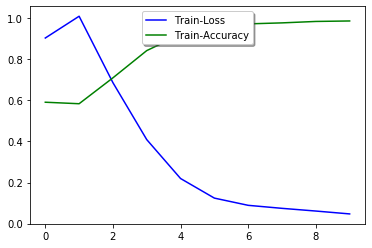

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

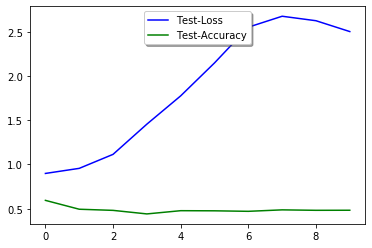

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 0.1 - Embedding+Conv1D  

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
model.add(Dropout(0.1))

model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())
model.add(Dense(250, activation='relu'))

model.add(Dense(5, activation='softmax'))
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 192, 50)           666750    
_________________________________________________________________
dropout_2 (Dropout)          (None, 192, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 190, 250)          37750     
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               62750     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1255      
Total params: 768,505
Trainable params: 768,505
Non-trainable params: 0
________________________________________________

In [0]:
results = model.fit(padded_train, Y, epochs=10, shuffle=True, validation_split=0.2, batch_size=64)

Train on 5579 samples, validate on 1395 samples
Epoch 1/10
5579/5579 [==============================] - 7s 1ms/sample - loss: 1.3071 - acc: 0.4420 - val_loss: 1.2771 - val_acc: 0.4459
Epoch 2/10
5579/5579 [==============================] - 0s 87us/sample - loss: 1.2582 - acc: 0.4526 - val_loss: 1.2867 - val_acc: 0.4459
Epoch 3/10
5579/5579 [==============================] - 0s 88us/sample - loss: 1.1612 - acc: 0.5291 - val_loss: 1.3340 - val_acc: 0.4007
Epoch 4/10
5579/5579 [==============================] - 0s 86us/sample - loss: 0.8543 - acc: 0.6872 - val_loss: 1.5640 - val_acc: 0.3785
Epoch 5/10
5579/5579 [==============================] - 1s 92us/sample - loss: 0.5544 - acc: 0.8012 - val_loss: 1.9219 - val_acc: 0.3699
Epoch 6/10
5579/5579 [==============================] - 1s 92us/sample - loss: 0.3651 - acc: 0.8640 - val_loss: 2.2933 - val_acc: 0.3656
Epoch 7/10
5579/5579 [==============================] - 1s 93us/sample - loss: 0.2506 - acc: 0.9145 - val_loss: 2.7024 - val_acc: 0

### Model 0.2 - Embedding+LSTM+Conv1D

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
# model.add(Dropout(0.1))
model.add(CuDNNLSTM(128, return_sequences=True))

model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

model.add(Dense(250, activation='relu'))

model.add(Dense(5, activation='softmax'))
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 192, 50)           666750    
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 192, 128)          92160     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 190, 250)          96250     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1255      
Total params: 919,165
Trainable params: 919,165
Non-trainable params: 0
_______________________________________________

In [0]:
results = model.fit(padded_train, Y, epochs=10, shuffle=True, validation_split=0.2, batch_size=64)

Train on 5579 samples, validate on 1395 samples
Epoch 1/10
5579/5579 [==============================] - 9s 2ms/sample - loss: 1.3068 - acc: 0.4298 - val_loss: 1.2744 - val_acc: 0.4459
Epoch 2/10
5579/5579 [==============================] - 2s 276us/sample - loss: 1.2540 - acc: 0.4617 - val_loss: 1.2992 - val_acc: 0.4358
Epoch 3/10
5579/5579 [==============================] - 2s 275us/sample - loss: 1.1055 - acc: 0.5558 - val_loss: 1.4194 - val_acc: 0.4165
Epoch 4/10
5579/5579 [==============================] - 2s 278us/sample - loss: 0.8738 - acc: 0.6585 - val_loss: 1.8092 - val_acc: 0.3892
Epoch 5/10
5579/5579 [==============================] - 2s 279us/sample - loss: 0.6244 - acc: 0.7636 - val_loss: 2.1871 - val_acc: 0.3577
Epoch 6/10
5579/5579 [==============================] - 2s 280us/sample - loss: 0.4703 - acc: 0.8242 - val_loss: 2.5580 - val_acc: 0.3527
Epoch 7/10
5579/5579 [==============================] - 2s 271us/sample - loss: 0.3795 - acc: 0.8659 - val_loss: 2.5987 - val_

## Image Data

In [0]:
# Train-test Split
np.random.RandomState(0)

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=0,stratify=Y)

# summarize dataset shape
print('Train', trainX.shape, trainY.shape)
print('Test', (testX.shape, testY.shape))

# summarize pixel values
print('Train', trainX.min(), trainX.max(), trainX.mean(), trainX.std())
print('Test', testX.min(), testX.max(), testX.mean(), testX.std())

Train (5590, 128, 128, 3) (5590, 3)
Test ((1398, 128, 128, 3), (1398, 3))
Train 0.0 1.0 0.4816630508151881 0.35140299093546473
Test 0.0 1.0 0.48126942935638023 0.35230589289975


In [0]:
# use classes weights to handle data imbalance
trainYcate = [np.argmax(i) for i in trainY]
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(trainYcate),trainYcate)
class_weights

array([0.56056959, 1.05811092, 3.68976898])

In [0]:
# reshape dataset to have a single channel
# width, height, channels = trainX.shape[1], trainX.shape[2], trainX.shape[3]
# trainX = trainX.reshape((trainX.shape[0], width,height,channels))
# testX = testX.reshape((testX.shape[0], width,height,channels))

# one hot encode target values
# trainY = to_categorical(trainY.factorize()[0])
# testY = to_categorical(testY.factorize()[0])

# create generator (1.0/255.0 = 0.003921568627451)
# datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True) # standardize
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False
)
datagen.fit(trainX)


# # prepare an iterators to scale images
# train_iterator = datagen.flow(trainX, trainY, batch_size=64)
# test_iterator = datagen.flow(testX, testY, batch_size=64)
# print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

# # confirm the scaling works
# batchX, batchy = train_iterator.next()
# print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

### Model 1 - CIFAR10 CNN 0.5699/0.5943(generator)
Conv-Conv-Maxpool-Dense
https://keras.io/examples/cifar10_cnn/

In [0]:
# define model
from keras import regularizers
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(width, height, channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
# model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
# model.add(Dropout(0.2))


model.add(Dense(3, activation='softmax'))
opt = Adam(lr=0.001, decay=1e-6)
# compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)       

In [0]:
es = callbacks.EarlyStopping(monitor='val_acc', mode='max')

# fit model with generator
results = model.fit(trainX, trainY,
         epochs=10,
         batch_size=64,
         shuffle=True,
#         validation_split=0.2
         validation_data=(testX,testY),
#          callbacks=[es],
         class_weight=class_weights          
         )
# model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=1)

# evaluate model
# _, acc = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
# print('Test Accuracy: %.3f' % (acc * 100))

Train on 5590 samples, validate on 1398 samples
Epoch 1/10
5590/5590 [==============================] - 13s 2ms/sample - loss: 0.9064 - acc: 0.5893 - val_loss: 0.9223 - val_acc: 0.5951
Epoch 2/10
5590/5590 [==============================] - 10s 2ms/sample - loss: 0.8941 - acc: 0.5946 - val_loss: 0.9148 - val_acc: 0.5951
Epoch 3/10
5590/5590 [==============================] - 10s 2ms/sample - loss: 0.8927 - acc: 0.5946 - val_loss: 0.9039 - val_acc: 0.5951
Epoch 4/10
5590/5590 [==============================] - 10s 2ms/sample - loss: 0.8954 - acc: 0.5946 - val_loss: 0.9062 - val_acc: 0.5951
Epoch 5/10
5590/5590 [==============================] - 10s 2ms/sample - loss: 0.8854 - acc: 0.5952 - val_loss: 0.9088 - val_acc: 0.5951
Epoch 6/10
5590/5590 [==============================] - 10s 2ms/sample - loss: 0.8669 - acc: 0.6054 - val_loss: 0.9044 - val_acc: 0.5937
Epoch 7/10
5590/5590 [==============================] - 10s 2ms/sample - loss: 0.8273 - acc: 0.6195 - val_loss: 0.9691 - val_acc: 

In [0]:
results = model.fit_generator(datagen.flow(trainX, trainY, batch_size=32),
                    steps_per_epoch=len(trainX) / 32, epochs=5,class_weight=class_weights, validation_data=(testX,testY))

NameError: ignored

In [0]:
model.evaluate(testX,testY)

1395/1395 [==============================] - 1s 392us/sample - loss: 0.8908 - acc: 0.5950


[0.8908236489928324, 0.5949821]

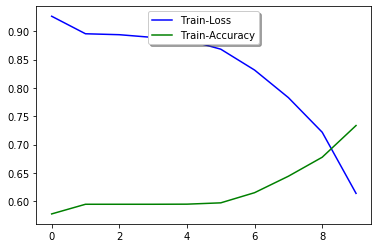

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

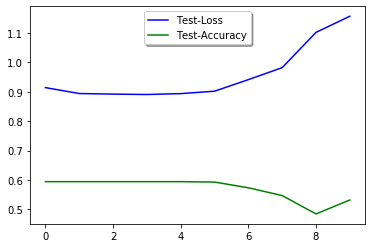

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 2 (Siyuan) 0.5176
Conv32-Conv64-Conv128-Dense128 (image only)

In [0]:
# 3 Conv model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 32768)           

In [0]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')
results = model.fit(trainX, trainY,
         epochs=10,
         batch_size=64,
         shuffle=True,
#         validation_split=0.5
         validation_data=(testX,testY),
#          callbacks=[es],
        class_weight=class_weights,
         )

Train on 5579 samples, validate on 1395 samples
Epoch 1/10
5579/5579 [==============================] - 3s 453us/sample - loss: 445.3209 - acc: 0.5108 - val_loss: 1.0861 - val_acc: 0.5835
Epoch 2/10
5579/5579 [==============================] - 2s 412us/sample - loss: 0.9502 - acc: 0.6051 - val_loss: 1.0256 - val_acc: 0.5728
Epoch 3/10
5579/5579 [==============================] - 2s 410us/sample - loss: 0.8120 - acc: 0.6440 - val_loss: 1.0696 - val_acc: 0.5720
Epoch 4/10
5579/5579 [==============================] - 2s 406us/sample - loss: 0.7327 - acc: 0.6761 - val_loss: 1.1273 - val_acc: 0.5685
Epoch 5/10
5579/5579 [==============================] - 2s 409us/sample - loss: 0.6747 - acc: 0.7046 - val_loss: 1.3054 - val_acc: 0.5584
Epoch 6/10
5579/5579 [==============================] - 2s 413us/sample - loss: 0.6300 - acc: 0.7150 - val_loss: 1.4535 - val_acc: 0.5326
Epoch 7/10
5579/5579 [==============================] - 2s 410us/sample - loss: 0.6019 - acc: 0.7410 - val_loss: 1.5079 - 

In [0]:
model.evaluate(testX,testY)

1395/1395 [==============================] - 0s 219us/sample - loss: 2.0189 - acc: 0.5176


[2.0189328944811256, 0.51756275]

In [0]:
results = model.fit_generator(datagen.flow(trainX, trainY, batch_size=64),
                    steps_per_epoch=len(trainX) / 64, epochs=10,class_weight=class_weights, validation_data=(testX,testY))

Epoch 1/10
88/87 [==============================] - 20s 232ms/step - loss: 4.3813 - acc: 0.4284 - val_loss: 1.3725 - val_acc: 0.4466
Epoch 2/10
88/87 [==============================] - 19s 220ms/step - loss: 1.2951 - acc: 0.4470 - val_loss: 1.3840 - val_acc: 0.4466
Epoch 3/10
88/87 [==============================] - 19s 220ms/step - loss: 1.2921 - acc: 0.4470 - val_loss: 1.3745 - val_acc: 0.4466
Epoch 4/10
88/87 [==============================] - 20s 223ms/step - loss: 1.2814 - acc: 0.4470 - val_loss: 1.3906 - val_acc: 0.4466
Epoch 5/10
88/87 [==============================] - 19s 220ms/step - loss: 1.2792 - acc: 0.4470 - val_loss: 1.3771 - val_acc: 0.4466
Epoch 6/10
88/87 [==============================] - 19s 217ms/step - loss: 1.2854 - acc: 0.4470 - val_loss: 1.3887 - val_acc: 0.4466
Epoch 7/10
88/87 [==============================] - 20s 223ms/step - loss: 1.2827 - acc: 0.4470 - val_loss: 1.3791 - val_acc: 0.4466
Epoch 8/10
88/87 [==============================] - 19s 221ms/step - 

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.show()
plt.plot(list(results.history.values())[2],'b-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.show()

### Model 3 - 0.445
Conv32-Maxpool-Conv64-Maxpool-Dense128

In [0]:
# define model

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_114 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 61504)             0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)             

In [0]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')
results = model.fit(trainX, trainY,
         epochs=20,
         batch_size=64,
         shuffle=True,
#         validation_split=0.2
         validation_data=(testX,testY),
         callbacks=[es],
        class_weight=class_weights,
         )

Train on 5579 samples, validate on 1395 samples
Epoch 1/20
5579/5579 [==============================] - 3s 569us/sample - loss: 177.1253 - acc: 0.5055 - val_loss: 1.0090 - val_acc: 0.5878
Epoch 2/20
5579/5579 [==============================] - 2s 397us/sample - loss: 0.9510 - acc: 0.5904 - val_loss: 0.9326 - val_acc: 0.5900
Epoch 3/20
5579/5579 [==============================] - 2s 394us/sample - loss: 0.8713 - acc: 0.6096 - val_loss: 0.9143 - val_acc: 0.5857
Epoch 4/20
5579/5579 [==============================] - 2s 389us/sample - loss: 0.8256 - acc: 0.6259 - val_loss: 0.9164 - val_acc: 0.5871
Epoch 5/20
5579/5579 [==============================] - 2s 388us/sample - loss: 0.7748 - acc: 0.6472 - val_loss: 0.9430 - val_acc: 0.5749
Epoch 6/20
5579/5579 [==============================] - 2s 393us/sample - loss: 0.7383 - acc: 0.6686 - val_loss: 0.9796 - val_acc: 0.5763
Epoch 7/20
5579/5579 [==============================] - 2s 388us/sample - loss: 0.6994 - acc: 0.6849 - val_loss: 1.0443 - 

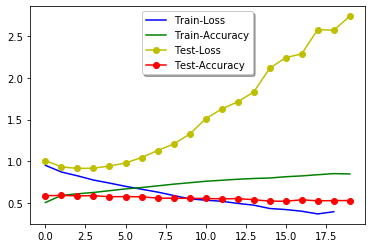

In [0]:
plt.plot(list(results.history.values())[0][1:],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 5 - CapsNet+Imgage
adapted from keras cifar10 model

In [0]:
from __future__ import print_function
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

In [0]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x
# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)
#     L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
#     return L

In [0]:
class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3)) #重新排序维度

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
#             o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            o = self.activation(tf.keras.backend.batch_dot(c, hat_inputs, [2, 2]))
#             #新版的Keras batch_dot 的结果和原作者expected shape不同
            if i < self.routings - 1:
                b = tf.keras.backend.batch_dot(o, hat_inputs, [2, 3])
#                 b = K.batch_dot(o, hat_inputs, [2, 3])
        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [0]:
batch_size = 64
epochs = 10
num_class = 3

# A common Conv2D model
input_image = Input(shape=(None, None, 3))
x = Conv2D(64, (3, 3), activation='relu')(input_image)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)


x = Reshape((-1, 128))(x)
capsule = Capsule(num_class, 32, 5, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

# we use a margin loss
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
# model.summary()

In [0]:
results = model.fit(
        X,
        Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
#         validation_data=(testX, testY),
        shuffle=True,
#         class_weight=class_weights
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5590 samples, validate on 1398 samples
Epoch 1/10





5590/5590 [==============================] - 12s 2ms/step - loss: 0.7470 - acc: 0.5454 - val_loss: 0.7963 - val_acc: 0.6052
Epoch 2/10
5590/5590 [==============================] - 10s 2ms/step - loss: 0.7662 - acc: 0.4070 - val_loss: 0.7928 - val_acc: 0.6052
Epoch 3/10
5590/5590 [==============================] - 10s 2ms/step - loss: 0.7903 - acc: 0.5921 - val_loss: 0.8097 - val_acc: 0.6052
Epoch 4/10
5590/5590 [==============================] - 10s 2ms/step - loss: 0.8096 - acc: 0.5921 - val_loss: 0.8094 - val_acc: 0.6052
Epoch 5/10
5590/5590 [==============================] - 10s 2ms/step - loss: nan - acc: 0.5796 - val_loss: nan - val_acc: 0.6052
Epoch 6/10
5590/5590 [==============================] - 10s 2ms/step - loss: nan - acc: 0.5921 - val_loss: nan - val_acc: 0.6052
Epoch 7/10
5590/5590 [==============================

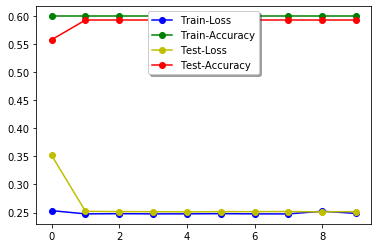

In [0]:
plt.plot(list(results.history.values())[0],'b-o',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g-o',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

CapsNet + Image + Data Augmentation

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(trainX)

    # Fit the model on the batches generated by datagen.flow().
results = model.fit_generator(
        datagen.flow(trainX, trainY, batch_size=batch_size),
        epochs=epochs,
        validation_data=(testX, testY),
        workers=4)


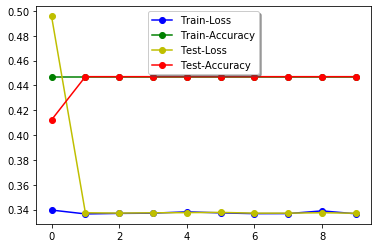

In [0]:
plt.plot(list(results.history.values())[0],'b-o',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g-o',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

## Image+Text


In [0]:
#text data
padded_train.shape

(6988, 192)

In [0]:
#image data
X.shape, Y.shape

((6988, 128, 128, 3), (6988, 3))

In [0]:
# use classes weights to handle data imbalance
trainYcate = [np.argmax(i) for i in Y]
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(trainYcate),trainYcate)
class_weights

array([0.56047482, 1.05830683, 3.69149498])

#### Model 4 - Concat CNN+LSTM

In [0]:
a = input_text = Input(shape = max_length)
a = Embedding(vocab_size, 100)(a)
a = CuDNNLSTM(128, return_sequences=True)(a)
a = CuDNNLSTM(128)(a)
a = Flatten()(a)
a = Dense(128, activation='relu')(a)

# output = Dense(5, activation='softmax')(a)
# Model_text_clr = Model(input_text,output)
# Model_text_clr.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy,optimizer = 'adam',metrics = ['accuracy'])
# Model_text_clr.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), activation='relu')(b)
b = Dropout(0.2)(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(64, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)
# output = Dense(5, activation='softmax')(b)
# Model_img_clr = Model(input_img,output)
# Model_img_clr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [0]:
#alternatives
b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), activation='relu')(b)
b = Conv2D(32, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(32, (3, 3), activation='relu')(b)
b = Conv2D(32, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)

In [0]:
combine = Concatenate(axis=-1,)([a,b])
combine = Dense(64, activation='relu')(combine)
combine = Dropout(0.2)(combine)
combine = Dense(32, activation='relu')(combine)
combine = Dropout(0.2)(combine)
output = Dense(3, activation='softmax')(combine)
Model_text_img_clr = Model([input_text,input_img],output)
Model_text_img_clr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Model_text_img_clr.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 126, 126, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 192)]        0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 126, 126, 32) 0           conv2d_6[0][0]                   
______________________________________________________________________________________________

In [0]:
plot_model(Model_text_img_clr, to_file='model4.png')

In [0]:
results = Model_text_img_clr.fit([padded_train,X], Y,
         epochs=3, #14 0.5122
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
         class_weight=class_weights
         )

Train on 5590 samples, validate on 1398 samples
Epoch 1/3
5590/5590 [==============================] - 7s 1ms/sample - loss: 0.1807 - acc: 0.9438 - val_loss: 2.1694 - val_acc: 0.4979
Epoch 2/3
5590/5590 [==============================] - 7s 1ms/sample - loss: 0.1202 - acc: 0.9651 - val_loss: 2.9264 - val_acc: 0.4707
Epoch 3/3
5590/5590 [==============================] - 7s 1ms/sample - loss: 0.0777 - acc: 0.9798 - val_loss: 3.7571 - val_acc: 0.4757


In [0]:
# Model_text_img_clr.evaluate()

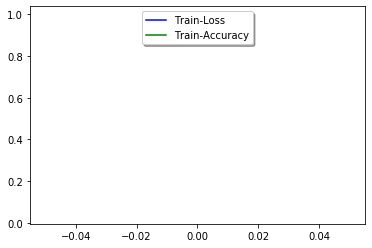

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

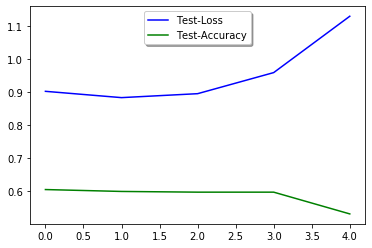

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

Output Model

In [0]:
pwd

'/content/drive/My Drive/SemEval_2020'

In [0]:
Model_text_img_clr.save('./models/Model_img_text_new.model')

### Model 6 - CapsNet+Text+Img

In [0]:
num_class = 5

t = input_text = Input(shape = (max_length,))
t = Embedding(vocab_size, 50)(t)
t = Dropout(0.2)(t)
t = CuDNNLSTM(64, return_sequences=True)(t)
t = Flatten()(t)

# t = Conv1D(128, 3, padding='valid', activation='relu', strides=1)(t)
# t = GlobalMaxPooling1D()(t)
# t = Dense(128, activation='relu')(t)

x = input_image = Input(shape=(width, height, channels))
t = Dropout(0.2)(t)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)

combine = Concatenate(axis=-1,)([t,x])
combine = Dense(128, activation='relu')(combine)
combine = Reshape((-1, 64))(combine)

capsule = Capsule(num_class, 16, 3, True)(combine)

output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)

Model6 = Model([input_text,input_image], output)
Model6.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
Model6.summary()

NameError: ignored

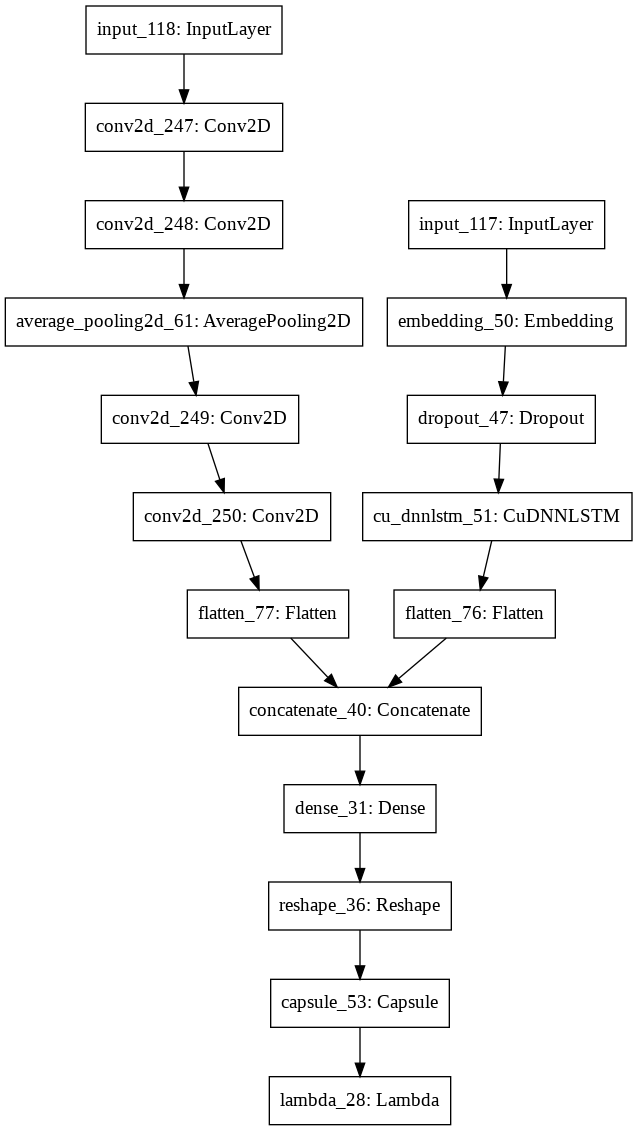

In [0]:
plot_model(Model6, to_file='model6.png')

In [0]:
results = Model6.fit(
        [padded_train,X],
        Y,
        batch_size=64,
        epochs=10,
        validation_split=0.2,
#         validation_data=(testX, testY),
        shuffle=True,
#         class_weight=class_weights
)

NameError: ignored

### Task-B

#### Single classification

In [0]:
data.head(1)

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive


In [0]:
data['sarcasm'].value_counts()

general            3505
twisted_meaning    1545
not_sarcastic      1544
very_twisted        394
Name: sarcasm, dtype: int64

In [0]:
data_test.head()

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment,s,h,o,m
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive,1,0,0,0
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive,1,1,0,1
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive,0,1,0,0
3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive,1,1,1,1
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral,1,0,1,0


In [0]:
# Y_s = data['sarcasm']
# Y_s = data['humour']
# Y_s = data['offensive']
# Y_s = data['motivational']

# # 0 - no label, 1 - lanel exists
# data['s'] = list(pd.Series(data['sarcasm'].factorize()[0]).replace([0,2,3],'1').replace(1,0).replace('1',1)) #['general', 'not_sarcastic', 'twisted_meaning', 'very_twisted']
# data['h'] = list(pd.Series(data['humour'].factorize()[0]).replace([1,2,3],1)) #['not_funny', 'very_funny', 'hilarious', 'funny']
# data['o'] = list(pd.Series(data['offensive'].factorize()[0]).replace([1,2,3],1)) #['not_offensive', 'very_offensive', 'slight', 'hateful_offensive']
# data['m'] = list(pd.Series(data['motivational'].factorize()[0])) #['not_motivational', 'motivational']

# data_train = data
Y_s = data_train['m']
# use classes weights to handle data imbalance
from sklearn.utils import class_weight
class_weights_s = class_weight.compute_class_weight('balanced',np.unique(Y_s),Y_s)
# Y_s = to_categorical(Y_s)
class_weights_s

array([0.77266696, 1.41686942])

In [0]:
model = Sequential()
model.add(Conv2D(32, (2, 2), padding='same', activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Conv2D(64, (2, 2), activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

In [0]:
es = callbacks.EarlyStopping(monitor='acc', mode='max')

# fit model with generator
results = model.fit(X, Y_s,
         epochs=3,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
        #  callbacks=[es],
         class_weight=class_weights_s      
         )

Train on 5590 samples, validate on 1398 samples
Epoch 1/3
5590/5590 [==============================] - 6s 1ms/sample - loss: 0.1686 - acc: 0.9426 - val_loss: 1.2378 - val_acc: 0.5780
Epoch 2/3
5590/5590 [==============================] - 6s 1ms/sample - loss: 0.0949 - acc: 0.9737 - val_loss: 1.4431 - val_acc: 0.5694
Epoch 3/3
5590/5590 [==============================] - 6s 1ms/sample - loss: 0.0762 - acc: 0.9834 - val_loss: 1.6424 - val_acc: 0.5758


In [0]:
a = input_text = Input(shape = 192)
a = Embedding(vocab_size, 100)(a)
a = CuDNNLSTM(128, return_sequences=True)(a)
a = CuDNNLSTM(128)(a)
a = Flatten()(a)
a = Dense(128, activation='relu')(a)

b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(64, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)

combine = Concatenate(axis=-1,)([a,b])
# combine = Dense(64, activation='relu')(combine)
combine = Dropout(0.2)(combine)
# combine = Dense(32, activation='relu')(combine)
# combine = Dropout(0.2)(combine)
output = Dense(1, activation='s')(combine)
Model_text_img_clr = Model([input_text,input_img],output)
Model_text_img_clr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Model_text_img_clr.summary()

In [0]:

es = callbacks.EarlyStopping(monitor='acc', mode='max')

results = Model_text_img_clr.fit([padded_train,X], Y_s,
         epochs=10,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
        # callbacks=[es],
        #  class_weight=class_weights_s      
)

#### Multi-label classification

In [0]:
# 0 - no label, 1 - lanel exists
data['s'] = list(pd.Series(data['sarcasm'].factorize()[0]).replace([0,2,3],'1').replace(1,0).replace('1',1)) #['general', 'not_sarcastic', 'twisted_meaning', 'very_twisted']
data['h'] = list(pd.Series(data['humour'].factorize()[0]).replace([1,2,3],1)) #['not_funny', 'very_funny', 'hilarious', 'funny']
data['o'] = list(pd.Series(data['offensive'].factorize()[0]).replace([1,2,3],1)) #['not_offensive', 'very_offensive', 'slight', 'hateful_offensive']


In [0]:
s_h_o = []
for i in data.index:
  concat =  ''.join([str(data['s'][i]),str(data['h'][i]),str(data['o'][i])])
#   concat =  [data['s'][i],data['h'][i],data['o'][i]]
  s_h_o.append(concat)
data['s_h_o']=s_h_o

In [0]:
Y_sho = data['s_h_o'].factorize()[0]
# use classes weights to handle data imbalance
from sklearn.utils import class_weight
class_weights_s = class_weight.compute_class_weight('balanced',np.unique(Y_sho),Y_sho)
Y_sho = to_categorical(Y_sho)
class_weights_s

array([ 6.51865672,  0.62571633,  0.79698905,  0.24808293,  2.22264631,
        2.69598765, 10.27647059, 22.3974359 ])

In [0]:

a = input_text = Input(shape = max_length)
a = Embedding(vocab_size, 100)(a)
a = CuDNNLSTM(128, return_sequences=True)(a)
a = CuDNNLSTM(128)(a)
a = Flatten()(a)
a = Dense(128, activation='relu')(a)

b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(64, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)

combine = Concatenate(axis=-1,)([a,b])
# combine = Dense(64, activation='relu')(combine)
combine = Dropout(0.2)(combine)
# combine = Dense(32, activation='relu')(combine)
# combine = Dropout(0.2)(combine)
output = Dense(8, activation='softmax')(combine)
Model_text_img_clr = Model([input_text,input_img],output)
Model_text_img_clr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Model_text_img_clr.summary()

es = callbacks.EarlyStopping(monitor='acc', mode='max')

results = Model_text_img_clr.fit([padded_train,X], Y_sho,
         epochs=15,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
        callbacks=[es],
         class_weight=class_weights_s      
)

Train on 5590 samples, validate on 1398 samples
Epoch 1/15
5590/5590 [==============================] - 6s 1ms/sample - loss: 1.7231 - acc: 0.4841 - val_loss: 1.4468 - val_acc: 0.4943
Epoch 2/15
5590/5590 [==============================] - 5s 983us/sample - loss: 1.4187 - acc: 0.5061 - val_loss: 1.4465 - val_acc: 0.4943
Epoch 3/15
5590/5590 [==============================] - 5s 978us/sample - loss: 1.3645 - acc: 0.5098 - val_loss: 1.4859 - val_acc: 0.4921
Epoch 4/15
5590/5590 [==============================] - 5s 979us/sample - loss: 1.2334 - acc: 0.5447 - val_loss: 1.5321 - val_acc: 0.4707
Epoch 5/15
5590/5590 [==============================] - 5s 981us/sample - loss: 1.0307 - acc: 0.6202 - val_loss: 1.7707 - val_acc: 0.4206
Epoch 6/15
5590/5590 [==============================] - 6s 991us/sample - loss: 0.7803 - acc: 0.7125 - val_loss: 2.1182 - val_acc: 0.4120
Epoch 7/15
5590/5590 [==============================] - 6s 989us/sample - loss: 0.5531 - acc: 0.7953 - val_loss: 2.6695 - val_

# Manual Test

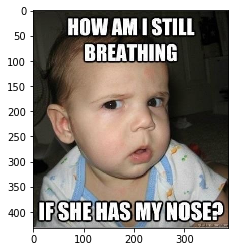

In [0]:
test_img = cv2.cvtColor(cv2.imread(PATH_IMG+data['Image_name'][1]), cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [0]:
data[:5]

,Image_name,OCR_extracted_text,Overall_Sentiment
0,10_year_10-year-challenge_1547788782.jpeg,The best of #10 YearChallenge! Completed in le...,very_positive
1,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
2,10_year_10-year-challenge-sweet-dee-edition-40...,10 Year Challenge - Sweet Dee Edition,positive
3,10_year_10-year-challenge-with-no-filter-47-hi...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral
4,10_year_10-years-challenge-about-humanity_o_72...,"1998: ""Don't get in car with strangers"" 2008: ...",negative


In [0]:
#prediction
temp = model.predict(X[800:813].reshape(-1,50,73,3))
temp_pre = [np.argmax(i) for i in temp]
temp_pre

[3, 2, 1, 1, 2, 1, 2, 2, 3, 2, 0, 1, 2]

In [0]:
#Ground Truth
temp = Y[800:813]
temp_truth = [np.argmax(i) for i in temp]
temp_truth

[2, 0, 2, 4, 2, 1, 0, 1, 3, 4, 0, 1, 1]

In [0]:
accuracy_score(temp_pre, temp_truth)
f1_score(temp_pre, temp_truth, average='micro')

0.38461538461538464

In [0]:
model.evaluate(X[800:813],Y[800:813])

13/13 [==============================] - 0s 573us/sample - loss: 1.4527 - acc: 0.7538


[1.4527454376220703, 0.75384617]

## Result Analysis

In [0]:
def resultAnalysis(model, data_x, data_y):
  y_pred = model.predict(testX)
  y_pred_cate = [np.argmax(i) for i in y_pred]
  print("Prediction classes count:\n",pd.Series(y_pred_cate).value_counts())
  y_truth = [np.argmax(i) for i in testY]
  print("\nTest classes count:\n",pd.Series(y_truth).value_counts())
  print(classification_report(y_truth,y_pred_cate))

In [0]:
resultAnalysis(model, testX, testY)

# Load model and test data



In [0]:
import pickle 
X_test = pickle.load(open("/content/drive/My Drive/SemEval_2020/TestX.pickle", "rb"))
data_test = pickle.load(open("/content/drive/My Drive/SemEval_2020/TestData.pickle", "rb"))
# X = X/255

In [0]:
data_test.shape, X_test.shape,X_test.min(),X_test.max()

((1878, 4), (1877, 128, 128, 3), 0, 255)

In [0]:
data_test.head(2)

,Image_name,Image_URL,OCR_extracted_text,corrected_text
0,chuck_chuck_norris_meme_10.jpg,https://gtmemes.com/wp-content/uploads/2019/03...,Some magicians can walk on water Chuck Norris...,Some magicians can walk on water Chuck Norris...
1,dr_evil_NDBB96K.png,https://i.imgur.com/NDBB96K.png,ONE MILLION DOLLARS made on imgur,ONE MILLION DOLLARS made on imgur


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
t = Tokenizer()
X_text = data['corrected_text']
X_text = [str(i) for i in X_text]
t.fit_on_texts(X_text)
vocab_size = len(t.word_index) + 1
print (vocab_size)
encoded_train = t.texts_to_sequences(X_text)
# max_length = max(list(map(lambda x: len(x), encoded_train)))
padded_train = pad_sequences(encoded_train, maxlen=192, padding='post')

6055


In [0]:
# from tensorflow.keras import models
# model = models.load_model('/content/drive/My Drive/SemEval_2020/models/Model_4_img_text.h5')

In [0]:
Model_text_img_clr.summary()

In [0]:
padded_train.shape, X.shape

((1878, 192), (1877, 128, 128, 3))

In [0]:
prediction = Model_text_img_clr.predict([padded_train[1:],X])
prediction.shape

(1877, 3)

In [0]:
prediction = model.predict(X_test)

In [0]:
temp_pre = [np.round(i[0],0) for i in prediction]
pd.Series(temp_pre).value_counts()

0.0    1384
1.0     493
dtype: int64

In [0]:
temp_pre.insert(0,0)
len(temp_pre)

1878

In [0]:
res = pd.DataFrame(temp_pre)
# res[1] = [9999 for i in range(len(res))]
# res[2] = [9999 for i in range(len(res))]
# res = res.replace(2,-1).replace(0,'p').replace(1,0).replace('p',1)
res[0].value_counts()

0.0    1385
1.0     493
Name: 0, dtype: int64

In [0]:
res.shape

res.to_csv('task8B_m.csv',header=False,index=False,sep=',')


In [0]:
res = Model_text_img_clr.predict([padded_train[1:],X])


In [0]:
res.shape

(1877, 8)